# Import Library

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from tqdm import tqdm
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from keras.layers import BatchNormalization
from keras.layers import Input, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import applications

# Data Visualization

In [2]:
train = list(os.walk('train'))

In [3]:
label_names = train[0][1]
dict_labels = dict(zip(label_names, list(range(len(label_names)))))
print(dict_labels)

{'asiatic rice borer': 0, 'brown plant hopper': 1, 'paddy stem maggot': 2, 'rice gall midge': 3, 'rice leaf caterpillar': 4, 'rice leaf roller': 5, 'rice leafhopper': 6, 'rice water weevil': 7, 'small brown plant hopper': 8, 'yellow rice borer': 9}


In [4]:
def dataset(path):
    images = []
    labels = []
    for folder in tqdm(os.listdir(path)):
        value_of_label = dict_labels[folder]

        for file in (os.listdir(os.path.join(path, folder))):
            path_of_file = os.path.join(os.path.join(path, folder), file)

            image = cv2.imread(path_of_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (150, 150))
            images.append(image)
            labels.append(value_of_label)

    images = np.array(images, dtype = 'float32')/255.0
    labels = np.array(labels)

    return images, labels

images, labels = dataset('train')
images, labels = shuffle(images, labels)

100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


In [5]:
images.shape

(3156, 150, 150, 3)

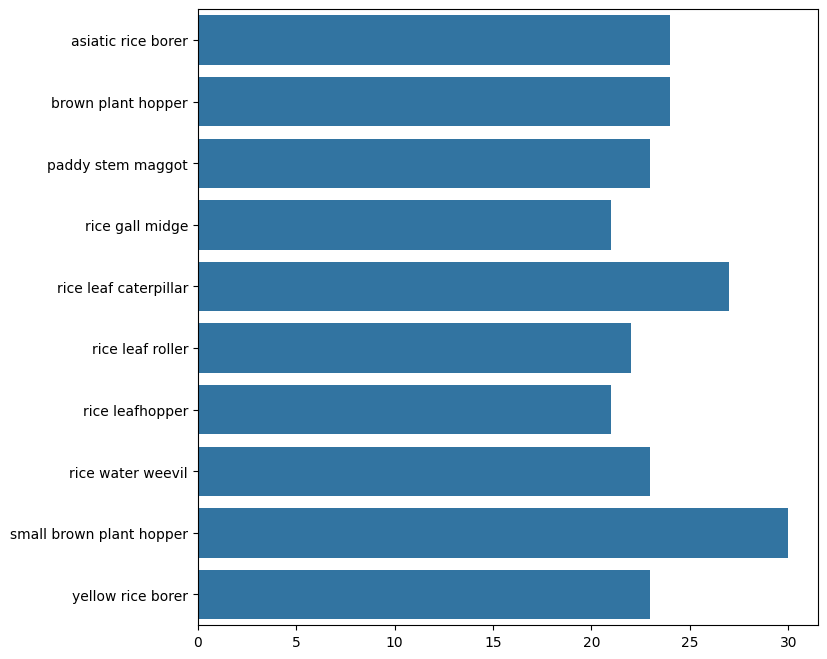

In [6]:
species = list(dict_labels.keys()) 
no_of_pest = []
for _ in range(1, len(species) + 1):
    no_of_pest.append(len(train[_][0]))
plt.figure(figsize = (8, 8))
sns.barplot(y=species, x=no_of_pest);

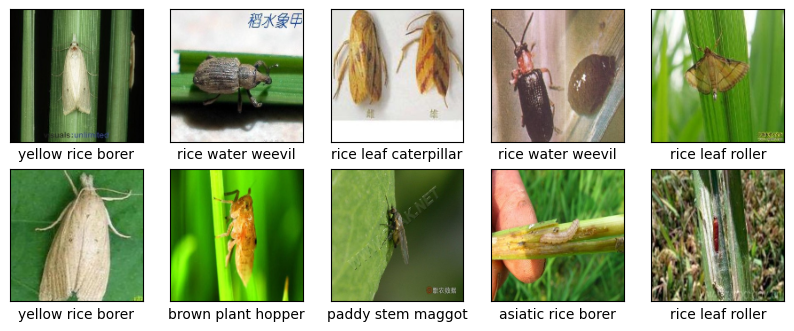

In [7]:
plt.figure(figsize = (10,10))
for _ in range(10):
    plt.subplot(5, 5, _+1)
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)
    data = images[_]
    plt.xlabel(label_names[labels[_]])
    plt.imshow(data);

# Load Images

In [8]:
image_size = (224, 224)
batch_size = 64
train_datagen = ImageDataGenerator(rescale = 1./255,
                            shear_range = 0.4,
                            zoom_range = 0.4,
                            horizontal_flip = True,
                            vertical_flip = True,
                            validation_split = 0.2)

In [9]:
train_ds = train_datagen.flow_from_directory('train',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'training',
                                      color_mode="rgb",)

val_ds = train_datagen.flow_from_directory('train',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'validation',
                                      color_mode="rgb")

Found 2530 images belonging to 10 classes.
Found 626 images belonging to 10 classes.


In [10]:
train_ds.class_indices

{'asiatic rice borer': 0,
 'brown plant hopper': 1,
 'paddy stem maggot': 2,
 'rice gall midge': 3,
 'rice leaf caterpillar': 4,
 'rice leaf roller': 5,
 'rice leafhopper': 6,
 'rice water weevil': 7,
 'small brown plant hopper': 8,
 'yellow rice borer': 9}

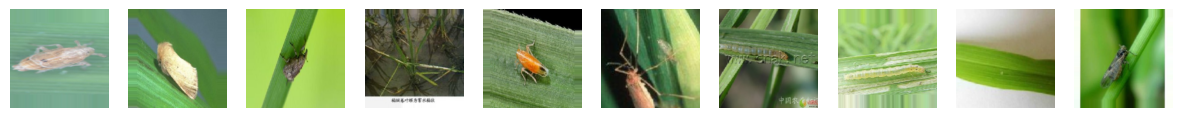

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15,15))

for i in range(10):
    image = next(train_ds)[0][0]
    image = np.squeeze(image)
    ax[i].imshow(image)
    ax[i].axis(False)

# ResNet152V2

In [12]:
res_base = applications.ResNet152V2(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
res_base.trainable = False

In [13]:
inputs = Input(shape=(224, 224, 3))

x = res_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation = 'softmax')(x)
res_model = Model(inputs, outputs)

In [14]:
res_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits = False),
    metrics= [keras.metrics.CategoricalAccuracy()],
)

In [15]:
epochs = 50
res_model.fit(train_ds, epochs=epochs, validation_data=val_ds)

c:\Users\nurri\.virtualenvs\multiclass-classification-resnet152v2-leEXAHKQ\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 288s 7s/step - categorical_accuracy: 0.4143 - loss: 2.0207 - val_categorical_accuracy: 0.6358 - val_loss: 1.1026
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 247s 6s/step - categorical_accuracy: 0.6601 - loss: 1.0012 - val_categorical_accuracy: 0.6677 - val_loss: 0.9950
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 238s 6s/step - categorical_accuracy: 0.7130 - loss: 0.8680 - val_categorical_accuracy: 0.6917 - val_loss: 0.9607
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 236s 6s/step - categorical_accuracy: 0.7464 - loss: 0.7882 - val_categorical_accuracy: 0.6869 - val_loss: 0.9741
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 236s 6s/step - categorical_accuracy: 0.7657 - loss: 0.7457 - val_categorical_accuracy: 0.7125 - val_loss: 0.9603
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 237s 6s/step - categorical_accuracy: 0.7667 - loss: 0.6842 - val_categorical_accuracy: 0.7093 - val_loss: 0.9358
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 236s 6s/step - categorical_accuracy: 0.7779 - loss: 0.63